In [ ]:
# Csomagok
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.linear_model import LinearRegression
from copy import deepcopy as dc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from itertools import chain




In [ ]:
# Adatok beszerzése

# a vakcinagyartok reszvenyadatai
# Astra-Zeneca, MERK", Johnson & Johnson, Pfizer

n_diff = 4
tickers = ["AZN", "MRK", "NVO", "JNJ", "PFE"]
start_date= "1997-01-01"
end_date = "2024-01-01"

raw_data = pd.DataFrame()
for ticker in tickers:
  data = yf.download(ticker, start = start_date, end = end_date)
  raw_data[ticker]= (data["Open"] + data["Close"] )/2

raw_data.reset_index(inplace=True)
raw_data["Date"] = raw_data["Date"].dt.date
raw_data.set_index("Date",inplace = True)

raw_data.dropna(inplace=True)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(raw_data)



                  AZN         MRK         NVO         JNJ        PFE
Date                                                                
1997-01-02  13.791667   38.048664    0.902500   24.906250  13.035658
1997-01-03  13.885417   38.913406    0.907500   25.093750  13.154254
1997-01-06  13.864583   39.479961    0.910000   25.343750  13.213552
1997-01-07  13.937500   39.479961    0.922500   25.343750  13.124605
1997-01-08  13.812500   39.420322    0.907500   25.593750  13.391445
...               ...         ...         ...         ...        ...
2023-12-22  66.645000  107.424999  102.935001  155.355003  28.420000
2023-12-26  66.500000  107.564999  102.619999  155.570000  28.420000
2023-12-27  67.454998  107.645000  103.170002  155.925003  28.540000
2023-12-28  67.425003  108.535000  104.010002  156.290001  28.700001
2023-12-29  67.364998  109.004997  103.500000  156.625000  28.785001

[6794 rows x 5 columns]


In [311]:
# Aattisztitás, data preprocessing

Trends = []

# TEACHER FORCING - Elshiftelés
raw_data["XAZN"] = raw_data["AZN"].shift(1)
raw_data["XXAZN"] = raw_data["XAZN"]

print(raw_data["JNJ"].shape)
raw_data["XAZN"][0] = 0 # egyenlre. a regresszióhoz, mivel a reszvenyei az elejn 0 korul
raw_data["XXAZN"] = raw_data["XAZN"]
# vannak ezert állítottam 0-ra

scaler = MinMaxScaler(feature_range=(-1,1))
data = scaler.fit_transform(raw_data)
#data = raw_data #-> ellenorzesre

# Leveszem regresszióval a linearis trendet
def remove_trend(data):
  x = np.arange(len(data)).reshape(-1, 1)
  reg_model = LinearRegression().fit(x, data)
  trend = reg_model.predict(x)
  Trends.append(trend)

  detrended_data = data - trend
  return detrended_data

# Ellenőrzésre
def identity_fun(data):
  return data

# Detrend each financial column
data = np.apply_along_axis(remove_trend, axis=0, arr=data)


(6794,)


In [ ]:
#Ellenorzes vegett
print(raw_data)
print(data)


                  AZN         MRK         NVO         JNJ        PFE  \
Date                                                                   
1997-01-02  13.791667   38.048664    0.902500   24.906250  13.035658   
1997-01-03  13.885417   38.913406    0.907500   25.093750  13.154254   
1997-01-06  13.864583   39.479961    0.910000   25.343750  13.213552   
1997-01-07  13.937500   39.479961    0.922500   25.343750  13.124605   
1997-01-08  13.812500   39.420322    0.907500   25.593750  13.391445   
...               ...         ...         ...         ...        ...   
2023-12-22  66.645000  107.424999  102.935001  155.355003  28.420000   
2023-12-26  66.500000  107.564999  102.619999  155.570000  28.420000   
2023-12-27  67.454998  107.645000  103.170002  155.925003  28.540000   
2023-12-28  67.425003  108.535000  104.010002  156.290001  28.700001   
2023-12-29  67.364998  109.004997  103.500000  156.625000  28.785001   

                 XAZN      XXAZN  
Date                        

In [ ]:
# Adat felbontása train, test, split idősorokra

train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

train_split_index = int(len(data) * train_ratio)
val_split_index = int(len(data) * (train_ratio + val_ratio))

train_data = data[:train_split_index]
val_data = data[train_split_index:val_split_index]
test_data = data[val_split_index:]


x_train = train_data[:,1:]
y_train = train_data[:,0]

x_test = test_data[:,1:]
y_test = test_data[:,0]

x_val = val_data[:,1:]
y_val = val_data[:,0]


# LSTM végére +1 dimenzió

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))




x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((4755, 6, 1), (4755, 1), (1020, 6, 1), (1020, 1), (1019, 6, 1), (1019, 1))

In [ ]:
# Ellenőrzés hogy helyes -e
print(x_train)
print("--------------------------------")
print(y_train)

[[[-0.05048855]
  [ 0.24099352]
  [ 0.08739475]
  [-0.49379797]
  [-0.28521508]
  [-0.28521508]]

 [[-0.03304762]
  [ 0.24092979]
  [ 0.08948782]
  [-0.48906961]
  [ 0.07718879]
  [ 0.07718879]]

 [[-0.02165161]
  [ 0.24081796]
  [ 0.09236222]
  [-0.48673417]
  [ 0.07950022]
  [ 0.07950022]]

 ...

 [[-0.20084753]
  [-0.01338974]
  [-0.13995188]
  [-0.02165609]
  [-0.13660326]
  [-0.13660326]]

 [[-0.1948436 ]
  [-0.00960579]
  [-0.13426466]
  [-0.04679064]
  [-0.12900139]
  [-0.12900139]]

 [[-0.19502962]
  [-0.01019858]
  [-0.1356407 ]
  [-0.05297377]
  [-0.11837635]
  [-0.11837635]]]
--------------------------------
[[ 0.09374871]
 [ 0.09655734]
 [ 0.09570582]
 ...
 [-0.15691684]
 [-0.1440062 ]
 [-0.13972015]]


In [ ]:
## PYTORCH BEÁLLÍTÁSOK

# Becsomagolom az adatokat egy pytorch adatszerkezetbe amit késobb ertelmezni tudok
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

        #self.sequence_length= 10

    def __len__(self):
        return len(self.x)


    def __getitem__(self, i):
      # N-> N probléma esetén:

      #input_sequence = self.x[i:i+self.sequence_length]
      #target_sequence = self.y[i+self.sequence_length]
      #return input_sequence, target_sequence

       # N-> 1 prébléma esetén (a feladat):
      return self.x[i], self.y[i]

# pytorch tensorok kialakítása, illetve a float64 értékek egységesítése
x_train= torch.tensor(x_train).float()
y_train= torch.tensor( y_train).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_val  = torch.tensor(x_val).float()
y_val = torch.tensor(y_val).float()


# A Datasetek
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

# Ellenorzes
x_train.shape,y_train.shape

# A loaderek Batch méretének bealitása:
my_batch_size = 50

# Loaderek létrehozása
train_loader = DataLoader(train_dataset, batch_size=my_batch_size, shuffle=False)
# A train loadernek azt állítom be hogy ne shuffle-ljen a barchek betoltésénél, hogy
# az időbeli patterneket is megtanuljuk
test_loader = DataLoader(test_dataset, batch_size=my_batch_size, shuffle=True)
# a Test-loaderben meghagyom a random shufflet hogy csökkentsem a tultanulast



In [ ]:
num_layers = 1


# ----------------------------------------------------------------------
# ---------------------------- Vanilla ---------------------------------
# ----------------------------------------------------------------------
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # Elég csak a hidden staterol gondoskodni
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

Vanilla_modell = SimpleRNN(1,6,1)

In [258]:

# ----------------------------------------------------------------------
# ------------------------------ LSTM ----------------------------------
# ----------------------------------------------------------------------

class LSTM(nn.Module): # instabil gradiens probléma megoldasara

  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size,
                        num_stacked_layers,
                        batch_first=True,
                        bidirectional = False) # Bidirectional false
    self.fc = nn.Linear(hidden_size,1)

  def forward(self, x):

    batch_size= x.size(0)
    #print(batch_size)

    # A kezdő tokenek (kezdő rejtett reprezentáció és cell state) 0-kkal való iniciallizálása
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :]) # REgressziós feladat -> Linear
    return out

LSTM_model = LSTM(1,6,2)
LSTM_model

LSTM(
  (lstm): LSTM(1, 6, num_layers=2, batch_first=True)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)

In [259]:
num_layers = 1

# ----------------------------------------------------------------------
# ----------------------------- GRU ------------------------------------
# ----------------------------------------------------------------------

class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleGRU, self).__init__()

        self.hidden_size = hidden_size

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])

        return out

GRU_model = SimpleGRU(1, 6, 1)


In [263]:
def flatten_recursive_iter(lst):
    return list(chain.from_iterable(map(flatten_recursive_iter, lst))) if isinstance(lst, list) else [lst]

model = GRU_model

MSE_output_list = []
MSE_prev_list = []
loss_function = nn.MSELoss()
output = None
epoch = 0

def train_one_epoch(output):

    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        if output != None:
          tmp = output.tolist()
          fl_tmp = flatten_recursive_iter(tmp)

          if(x_batch.shape[0] == my_batch_size and output.shape[0]== my_batch_size):
            for i in range(len(fl_tmp)):
              (x_batch[:, -1, :])[i, 0] = fl_tmp[i]


        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Ha ki akarnám iratni a loss-t 100 -anként:

        #if batch_index % 100 == 99:
        #    avg_loss_across_batches = running_loss / 100
        #    print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
        #                                            avg_loss_across_batches))
        #    running_loss = 0.0


def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    running_loss_daily = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            loss_d = loss_function((x_batch[:, -1, :]),y_batch)

            running_loss += loss.item()
            running_loss_daily += loss_d.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    avg_loss_daily = running_loss_daily / len(test_loader)
    MSE_output_list.append(avg_loss_across_batches)
    MSE_prev_list.append(avg_loss_daily)


    print('MSE output-y_batch Loss: {0:.3f}'.format(avg_loss_across_batches))
    print("MSE daily diff benchmark: {0:.3f}".format(avg_loss_daily))
    print('***************************************************')
    print()


def check_stuff():
  print()
  #print((x_batch[:, -1, :])[0, 0])
  #print(x_batch.shape)
  #print(output.shape)

  #x_batch[:, -1, :] = output
  #print(x_batch[:, -1, :])
  #print(fl_tmp)
  #break
  #print(x_batch[:, -1, :])
  #print(x_batch[:, -1, :].shape)
  #break
  #for inp in output:
  #    print(inp.shape)

  #print(output.shape)
  #rev_x_batch = reversed(x_batch)
  #print(x_batch[:, -1, 0].shape)
  #print("----------------------")
  #print(reversed(output[:, 0]).shape)
  #print(x_batch[:, -1, 0].shape)
  #print(x_batch[:, -1, 0][:65].shape)
  #x_batch[:, -1, -1] = output.view(-1)
  #pred_tensor = output.view(-1)

  #x_batch[4] = output

In [267]:
# MODELL EPITESE

MSE_output_list = []
MSE_prev_list = []
output = None
learning_rate = 0.001
epochs = 100
lambda_t = 0.0000001

# 5 darab input (4 reszvenyar + 1 lag), 1 rejtett reprezentacio minden input vektorba, 1 rekurrens reteg sackelve (mint oran)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,weight_decay = lambda_t, amsgrad=True) # nadam, oran tanultuk hogy az a egoptimalisabb hiszen alkalmaz momentumot es SGD-t is
loss_fn = nn.MSELoss() # Regresszio -> MSE

for epoch in range(epochs):

    train_one_epoch(None)
    check_stuff()
    validate_one_epoch()


Epoch: 1

MSE output-y_batch Loss: 0.032
MSE daily diff benchmark: 0.007
***************************************************

Epoch: 2

MSE output-y_batch Loss: 0.021
MSE daily diff benchmark: 0.007
***************************************************

Epoch: 3

MSE output-y_batch Loss: 0.013
MSE daily diff benchmark: 0.007
***************************************************

Epoch: 4

MSE output-y_batch Loss: 0.009
MSE daily diff benchmark: 0.007
***************************************************

Epoch: 5

MSE output-y_batch Loss: 0.005
MSE daily diff benchmark: 0.007
***************************************************

Epoch: 6

MSE output-y_batch Loss: 0.003
MSE daily diff benchmark: 0.007
***************************************************

Epoch: 7

MSE output-y_batch Loss: 0.003
MSE daily diff benchmark: 0.007
***************************************************

Epoch: 8

MSE output-y_batch Loss: 0.002
MSE daily diff benchmark: 0.007
*********************************************

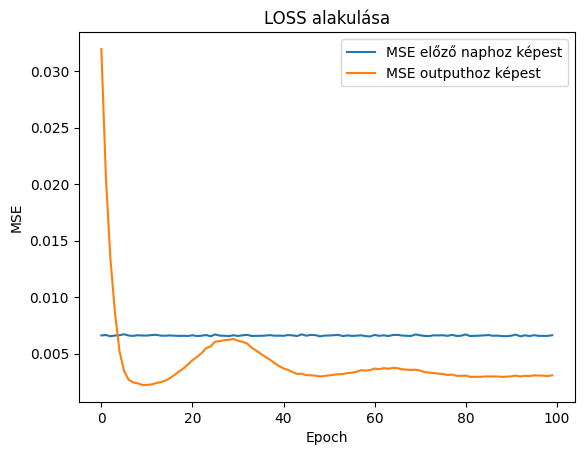

In [268]:
plt.plot(MSE_prev_list, label ="MSE előző naphoz képest")
plt.plot(MSE_output_list, label="MSE outputhoz képest")
plt.title("LOSS alakulása")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

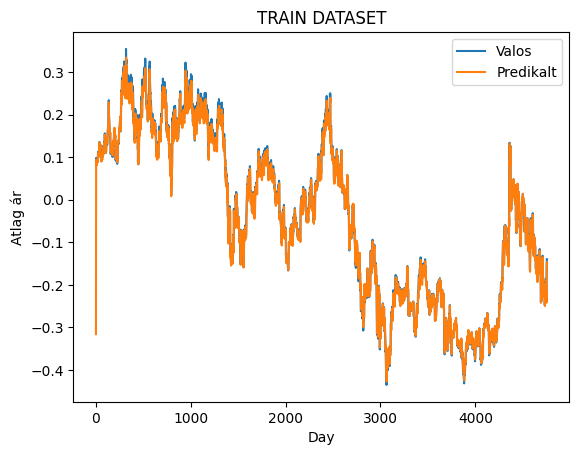

In [269]:
with torch.no_grad():
    predicted = model(x_train).numpy()

plt.plot(y_train, label='Valos')
plt.plot(predicted, label="Predikalt")
plt.title("TRAIN DATASET")
plt.xlabel('Day')
plt.ylabel('Atlag ár')
plt.legend()
plt.show()

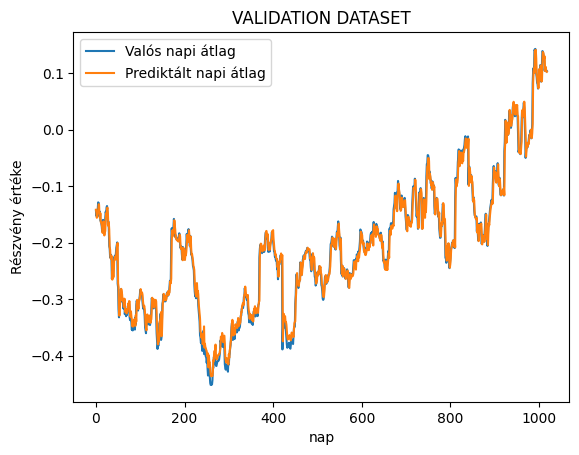

In [270]:


with torch.no_grad():
    predicted = model(x_val).numpy()

plt.plot(y_val, label="Valós napi átlag")
plt.plot(predicted, label="Prediktált napi átlag")
plt.xlabel('nap')
plt.ylabel('Részvény értéke')
plt.title("VALIDATION DATASET")
plt.legend()
plt.show()

In [343]:
# Pár példa kiiratása

# A validation halmaz lineáris trendjeinek meghatározása
val_index = int(np.array(Trends).shape[1]*0.85)
val_trends = np.array(Trends)[-1][val_index+1:]

# Random indexek a validation halmazbol
random_indices = torch.randperm(len(x_val))[:5]
max_AZN = raw_data["AZN"].max()
min_AZN = raw_data["AZN"].min()

# Min-max normalization visszafordítása
x_val_rev = x_val[:,-1,:] * (max_AZN - min_AZN) + min_AZN
x_val_rev = x_val_rev.numpy().flatten()

y_val_rev = y_val * (max_AZN - min_AZN) + min_AZN
pred_rev  = predicted * (max_AZN - min_AZN) + min_AZN
val_trends = val_trends * (max_AZN - min_AZN) + min_AZN

# Trendek hozzáadása
for idx in random_indices:
    print(f"Index: {idx}, Predicted: {pred_rev[idx].item() + val_trends[idx]:.3f}, Actual: {y_val_rev[idx].item() + val_trends[idx]:.3f} , Previous Day's price: {x_val_rev[idx].item() + val_trends[idx]:.3f}")



Index: 329, Predicted: 20.479, Actual: 20.796 , Previous Day's price: 23.727
Index: 65, Predicted: 19.395, Actual: 17.711 , Previous Day's price: 22.616
Index: 353, Predicted: 19.925, Actual: 19.607 , Previous Day's price: 23.357
Index: 905, Predicted: 41.237, Actual: 41.528 , Previous Day's price: 42.219
Index: 762, Predicted: 38.605, Actual: 38.373 , Previous Day's price: 39.718
